In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from src.env.DunderBotEnv import DunderBotEnv
import src.run as run
import src.load as load
import src.preprocess as preprocess
import src.data_raw as data_raw
from src.util.run_util import create_timedelta_and_plot

from src.util.config import get_config
config = get_config()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

loading config from config/config.yml


# TODO:

- Scale colors better for plotted trades
- Go back to basic concepts like epochs to understand the Discord discussions perfectly. Kinda link their terminology to the one of stable baselines.
- Double check all available reward functions and classes are fast
    * Dump or rewrite the incremental net worth
- Experiment: Test different setting of exploration
- Experiment: longer training
- Experiment: use minute granularity data
- Experiment: smaller and more updates, i.e. fewer cores.
- Experiment: Use discounted rewards during training to stop training?
- Experiment: add slow TI features
- Experiment: smaller time window for sortino calculation
- Experiment: Discover new promising reward functions (e.g. something more direct on profits?)
- Calculate and show daily and 30 day trading overturn in old fashioned currency
- Download and enable order book data (how do you aggregate orders in time bins?)
- Experiment with orders as features
    * e.g. shape of order book etc.
- Experiments: Test additional models to PPO2. Be careful though, many require different setting in which to run optimally.
- Consider other periods for TI:s, e.g. see https://medium.com/@coinloop/technical-analysis-indicators-and-how-to-use-them-aa0fa706051 and consider having some fixed in time (controlled in config)
- Optimize to save some time every iteration
- Fetch agent hyperparameters from RL Zoo
- Consider a different training structure, where we train on many smaller rounds, perhaps spread out in time more.
- Hyperparameter search
- Build more advanced slippage handling
- Correct for displaced index due to specified TI NaNs (likely uneccessary for all our use cases)
- Get the available LSTM networks working and compare with MLP (tips: https://github.com/hill-a/stable-baselines/issues/646). NOTE: LSTMs also need state during prediction as well as proper env counts for train and test (https://github.com/hill-a/stable-baselines/issues/166 and https://stable-baselines.readthedocs.io/en/master/guide/examples.html#recurrent-policies). Also: https://github.com/hill-a/stable-baselines/issues/308
- Understand more advanced custom policy networks better. See for exampåle  discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759, https://github.com/hill-a/stable-baselines/issues/278, https://github.com/hill-a/stable-baselines/issues/646)
- Check float number type



# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (discrete)
- wrapped running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Add commission and slippage
- Refactor current reward and add some new ones
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add portfolio features
- Add reward output
- setup train/test functionality
- Enable saving/loading trained models
- Normalize observations
- Add env checker (disbled by default, but passed)
- lock down the seeds
- Add finer temporal resolution in data (minute granularity)
- Add support for higher frequency data: NaN handling and pushed starting timestamp
- Add technical indicator features
- Add benchmarks
- Add dynamic data download and preparation by downloading all transactions -> render OHLC in multiple time granularities
- Add full support for multiprocessing
- Suppress tensorflow warnings
- Substantial time optimizations to avoid growing time per iteration of training
- Substantial memory savings from only saving data we need during training
- Added flag to refresh data
- No data copy when building Docker cotainer -- MUCH faster Docker builds
- Properly save model, normalization statistics, and some useful meta data
- Save result plots from prediction in model folders
- The reward range is reward specific
- Refactored the trading class: decreased complexity and duplicate calculations
- Proper commission and slippage support (beta distr for slippage)
- Revisited TIs: added TI features and a forward looking check
- Restructured trade code, and added absolute trade values as config option

# Run

In [2]:
record_steptime = False
force_refresh = False

In [3]:
%%time
data_raw.download_and_process(force_refresh=force_refresh)
df = load.load_OHLC_data()
df = preprocess.preprocess_data(df=df, include_slow_features=False)

config.n_cpu=1
env = run.setup_env(df=df, record_steptime=record_steptime)

Processed data available locally, no downloading and raw data processing needed.
LOAD: Loading data with 23615326 samples
PREPROCESS: Dropping 0 NaNs out of 23615326 samples (0.0%) from input file
PREPROCESS: Dropping unused data, 23615326 -> 1760 samples
PREPROCESS: Performing check of forward lookingness of TIs
PREPROCESS: Adding technical features...
Done.
PREPROCESS: Performing NaN/inf check on data...
Done.
Setting up environment using 1 cores...
Resetting to timesteps: start 23613866 (2020-09-28 03:06:11), end 23615075 (2020-09-28 09:31:33)
Done.
CPU times: user 3.55 s, sys: 4.07 s, total: 7.62 s
Wall time: 11 s


In [4]:
# EXPERIMENT: with only gentle commission AND new TIs AND 10 data_n_timesteps again

In [5]:
%%time
model = run.train(env=env, n_infoboxes=10)
if record_steptime:
    create_timedelta_and_plot(model=model)

RUN: Training for 1500 serial timesteps and 1500 total timesteps...
Resetting to timesteps: start 23613866 (2020-09-28 03:06:11), end 23615075 (2020-09-28 09:31:33)
-------------------------------------
| approxkl           | 7.438001e-05 |
| clipfrac           | 0.0          |
| explained_variance | -0.00607     |
| fps                | 220          |
| n_updates          | 1            |
| policy_entropy     | 2.1971543    |
| policy_loss        | -0.004954362 |
| serial_timesteps   | 128          |
| time_elapsed       | 3.31e-05     |
| total_timesteps    | 128          |
| value_loss         | 2.9204154    |
-------------------------------------
-------------------------------------
| approxkl           | 4.221961e-05 |
| clipfrac           | 0.0          |
| explained_variance | -1.38        |
| fps                | 348          |
| n_updates          | 2            |
| policy_entropy     | 2.197018     |
| policy_loss        | -0.003696475 |
| serial_timesteps   | 256          |

RUN: Loading files from ./data/models/19/
Loading a model without an environment, this model cannot be trained until it has a valid environment.
RUN: Model connected with env
RUN: Predicting for 239 timesteps
Resetting to timesteps: start 23615085 (2020-09-28 09:35:32), end 23615325 (2020-09-28 10:16:00)
Rendering TradingChartStatic for index steps 23615085 (2020-09-28 09:35:32) through 23615324 (2020-09-28 10:15:35)


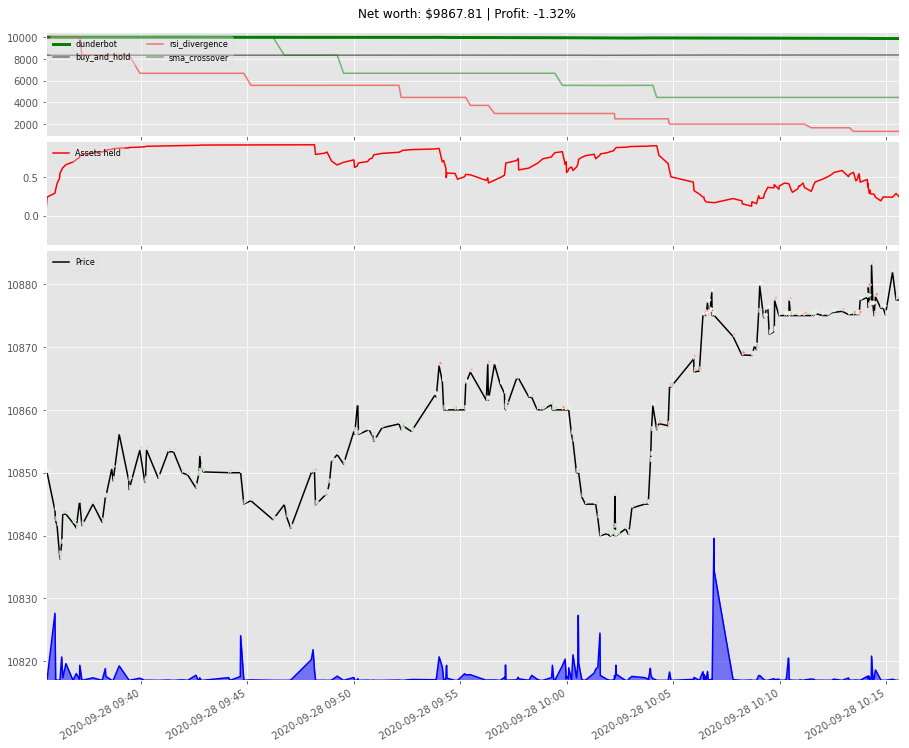

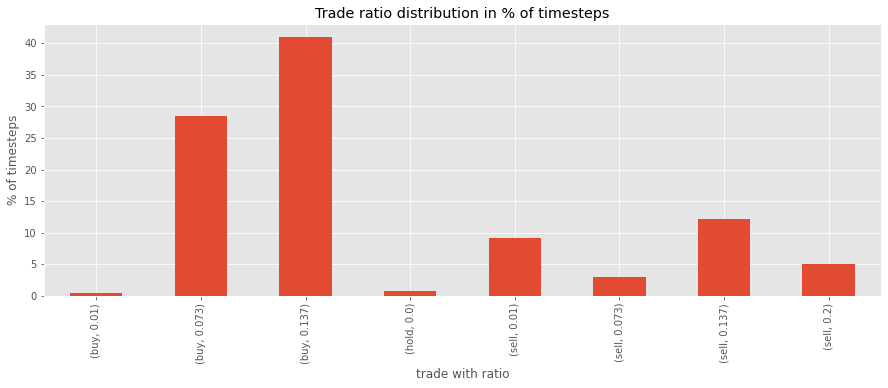

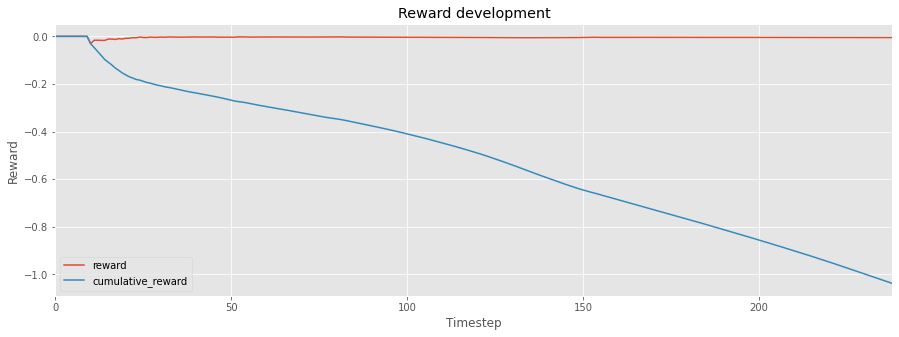

CPU times: user 9.46 s, sys: 831 ms, total: 10.3 s
Wall time: 9.53 s


In [6]:
%%time
run.predict(df=df, rendermode='plots')

In [7]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 23365346,
 'net_worths': [10000,
  9995.01,
  9994.69,
  9995.316,
  9995.405,
  9997.328,
  9995.358,
  9994.763,
  9995.814,
  9994.53,
  9996.954,
  9994.869,
  9995.292,
  10000.79,
  9995.913,
  9995.546,
  9996.759,
  9996.863,
  9996.635,
  9998.643,
  9999.586],
 'trades': [{'step': 23365326,
   'amount': 0.23513827,
   'total': 2500.0,
   'type': 'buy',
   'action_amount': 0.25},
  {'step': 23365327,
   'amount': None,
   'total': None,
   'type': 'hold',
   'action_amount': None},
  {'step': 23365328,
   'amount': None,
   'total': None,
   'type': 'hold',
   'action_amount': None},
  {'step': 23365329,
   'amount': None,
   'total': None,
   'type': 'hold',
   'action_amount': None},
  {'step': 23365330,
   'amount': None,
   'total': None,
   'type': 'hold',
   'action_amount': None},
  {'step': 23365331,
   'amount': None,
   'total': None,
   'type': 'hold',
   'action_amount': None},
  {'step': 23365332,
   'amount': None,
   'total': None,
   'type': 'h

In [7]:
x.keys()

dict_keys(['current_step', 'net_worths', 'trades', 'returns', 'account_history', 'rewards'])

In [5]:
import numpy as np
np.linspace(config.trade.min_absolute_trade_value, config.trade.max_absolute_trade_value, config.action_strategy.n_value_bins)

array([ 200.,  800., 1400., 2000.])

In [2]:
from src.env.trade.TradeStrategies import TradeStrategyAbsolute

In [3]:
trade_strategy = TradeStrategyAbsolute()

In [7]:
for n in range(0,9):
    print(f'{n}: {trade_strategy._translate_action(n, 7600)}')
    

0: ('buy', 0.02631579)
1: ('buy', 0.10526316)
2: ('buy', 0.18421053)
3: ('buy', 0.26315789)
4: ('sell', 0.02631579)
5: ('sell', 0.10526316)
6: ('sell', 0.18421053)
7: ('sell', 0.26315789)
8: ('hold', None)


# TODO action class:
- align currencies -- now absolute class returns USD and ratio class BTC
- test
- move choice to config
- feel good about yourself -- one step closer to OOP heaven.

In [7]:
import matplotlib
cmap = matplotlib.cm.get_cmap('Greens')

In [11]:
cmap(1)

(0.9664129181084199, 0.9873740868896579, 0.9582006920415225, 1.0)